# Titanic: Machine Learning from Disaster

# The Challenge

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc). 

# Tools we would need

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, median_absolute_error, max_error, explained_variance_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
from xgboost import XGBRegressor, plot_importance 

from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout
from keras.optimizers import RMSprop 
from keras.callbacks import EarlyStopping 
import keras

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import threading
import re

sns.set()

TrainData =  pd.read_csv('input/train.csv')
TestData = pd.read_csv('input/test.csv')

Using TensorFlow backend.


# Feature engineering

## Interpolation of missing values

One can notice that in traing and testing data sets combined there are:
- **1014** passengers with missing `Cabin`
- **418** passengers with missing `Survived` value
- **263** passengers with missing `Age`
- **2** passengers with missing `Embarked` port
- **1** record with missing `Fare` value

We will try to approximate those values below.

In [2]:
traind = TrainData.copy()
testd = TestData.copy()
td_merged = traind.append(testd, ignore_index=True)
td_merged.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Retrieve Title from Name

In [3]:
# Retrieve title from Name, we will use it as a feature
for index, person in td_merged.iterrows():
    found = re.match(r".+ (.+\.).*", person.Name)
    if found:
        td_merged.loc[index, 'Title'] = found.group(1)

td_filtered = td_merged.drop(['PassengerId','Name'],axis=1)

### Fill missing `Embarked` values

In [4]:
# According to publicly available report, those 2 ladies embarked in Southampton
td_filtered[['Embarked']] = td_filtered[['Embarked']].fillna('S')

### Fill missing `Fare` value

In [5]:
# There's only 1 missing fare for a senior citezen, we'll use a median fare
# among other people on board of the same age
missing_fare = float(td_filtered[['Pclass','Age','Fare']]
                     [(td_filtered.Age > 50) & (td_filtered.Pclass == 3)]
                     .groupby(['Pclass']).median().Fare)
td_filtered[['Fare']] = td_filtered[['Fare']].fillna(missing_fare)

### Use `Cabin`'s first letter as sector identifier on the ship

In [6]:
# Use first cabin latter to distinguish location on the ship
td_filtered.Cabin = td_filtered.Cabin[td_filtered.Cabin.notnull()].apply(lambda c: c[0])

## Categorical feature encoding
* `Sex` - we have discovered only 2 possible genders in the data: _male_ and _female_
* `Ticket` - some tickets are reoccurring, perhaps shared among passengers tagging along in group (family members, tourists, friends, etc.)
* `Cabin` - Some cabins are also shared among passengers
* `Embarked` - this feature has 3 ports, some of the passengers (2 ladies from _Southampton_ ) have this field missing, we will manually populate those entries, as this information is publically available
* `Title` - We will extract title (_Mr._ , _Ms._ , _Mrs._ , etc.) from the name. Perhaps, it's worth to have a look at surname, and play around with that feature to predict survival rate of particular family members but for now we will drop it and use title only.

Apart from `Name`, we are also dropping `PassengerId` to avoid our models allocating excessive weights to irrelevant features.

In [7]:
categorical_features = ['Sex','Cabin','Embarked', 'Ticket', 'Title']
encoders = dict()
for feature in categorical_features:
    enc = LabelEncoder()
    encoders[feature] = enc
    td_filtered.loc[:,feature] = enc.fit_transform(td_filtered[feature].astype(str))

## Feature relationship analysis

In this step we will discover how different features correlate with each other and prepare a set of important variables to feed to our predictive models later.

### Heatmap

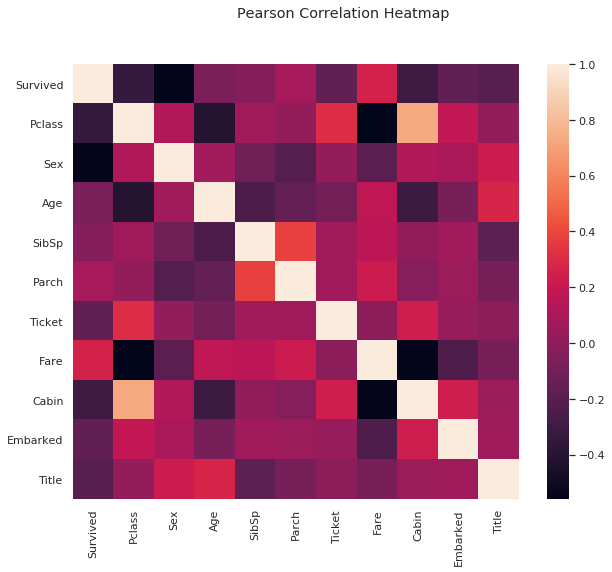

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
Survived,1.00,-0.34,-0.54,-0.08,-3.53e-02,0.08,-0.17,0.26,-3.01e-01,-0.17,-0.20
Pclass,-0.34,1.00,0.12,-0.41,6.08e-02,0.02,0.31,-0.56,7.35e-01,0.19,0.02
Sex,-0.54,0.12,1.00,0.06,-1.10e-01,-0.21,0.02,-0.19,1.25e-01,0.10,0.22
Age,-0.08,-0.41,0.06,1.00,-2.44e-01,-0.15,-0.09,0.18,-3.12e-01,-0.08,0.27
SibSp,-0.04,0.06,-0.11,-0.24,1.00e+00,0.37,0.06,0.16,7.95e-03,0.07,-0.18
Parch,0.08,0.02,-0.21,-0.15,3.74e-01,1.00,0.05,0.22,-3.44e-02,0.04,-0.09
Ticket,-0.17,0.31,0.02,-0.09,6.39e-02,0.05,1.00,-0.01,2.33e-01,0.03,-0.01
Fare,0.26,-0.56,-0.19,0.18,1.60e-01,0.22,-0.01,1.00,-5.47e-01,-0.24,-0.08
Cabin,-0.30,0.73,0.13,-0.31,7.95e-03,-0.03,0.23,-0.55,1.00e+00,0.23,0.05
Embarked,-0.17,0.19,0.10,-0.08,6.56e-02,0.04,0.03,-0.24,2.31e-01,1.00,0.06


In [8]:
pd.set_option('precision',2)
plt.figure(figsize=(10, 8))
sns.heatmap(td_filtered.corr())
plt.suptitle("Pearson Correlation Heatmap")
plt.show();
td_filtered.corr()

### Closer look on `Gender`, `Age` and `Class` 

From age and gender insights we can observe that passengers of the First class got the best survival rate followed by the Second class and the Third as the last one. Probably because passengers of the 3rd class ended up to be locked in their cabins, that might have been done to reduce sinking rate of the ship so that more lifes could have be saved.

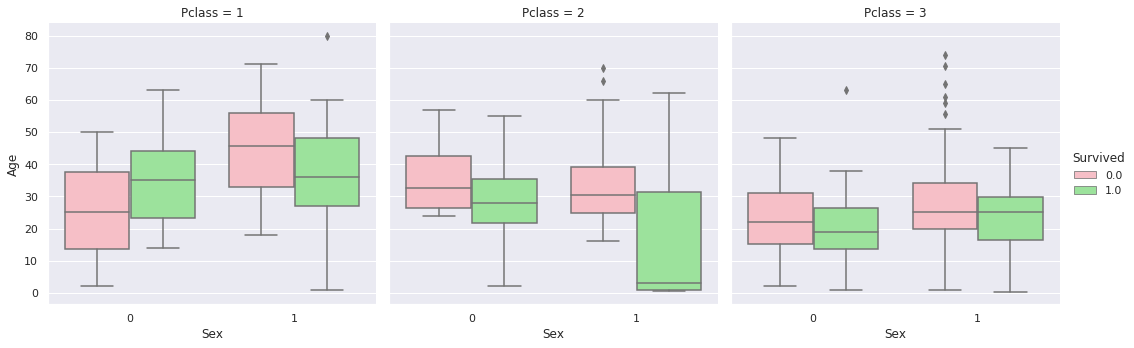

In [9]:
sns.catplot(x='Sex', y='Age', hue='Survived', data=td_filtered, kind="box", col='Pclass',
               palette=['lightpink','lightgreen'])

## Feature recovery

### Regression analysis of `Age`

For this model we are going to drop `Ticket` feature here, as it reduces error rate of prediction.

In [10]:
td_with_age = td_filtered[(~td_filtered.Age.isnull())].drop(['Ticket'], axis=1)
td_without_age = td_filtered[(td_filtered.Age.isnull())].drop(['Ticket','Age'], axis=1)

X = td_with_age.drop(['Age'], axis=1)
Y = td_with_age.Age

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=10)


#### Gradient boosting with XGBoost

R2 Score: 0.4536080662839158
MedAE: 4.405479431152344
Max Error: 29.71544647216797
ExpVar score: 0.4565557544127046


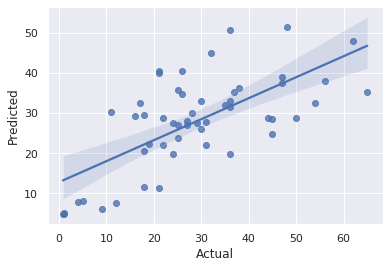

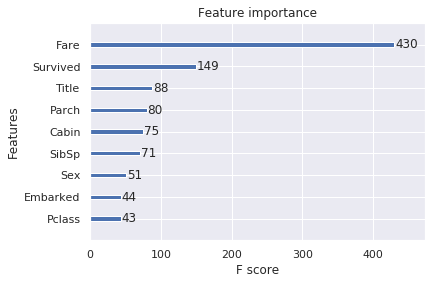

In [11]:
modelXGB = XGBRegressor(n_estimators=10000)
modelXGB.fit(X_train, y_train, early_stopping_rounds=10, 
             eval_set=[(X_test, y_test)], verbose=False)
predictions = modelXGB.predict(X_test)
print('R2 Score: %s' % r2_score(y_test.to_numpy(), predictions))
print('MedAE: %s' % median_absolute_error(y_true=y_test.to_numpy(),y_pred=predictions))
print('Max Error: %s' % max_error(y_true=y_test.to_numpy(),y_pred=predictions))
print('ExpVar score: %s' % explained_variance_score(y_true=y_test.to_numpy(),y_pred=predictions))

temp = pd.DataFrame()
temp['Actual'] = y_test
temp['Predicted'] = predictions
sns.regplot(x='Actual',y='Predicted',data=temp)

plot_importance(modelXGB)

plt.show()

**48%** - So far this is the closest our model achieved, but the variance yet asks for attention...

#### Populating missing `Age` values with results of our prediction

In [12]:
predictions = modelXGB.predict(td_without_age)
td_age_restored = td_without_age.copy()
td_age_restored.loc[:,'Age'] = predictions
td_filtered.update(td_with_age.append(td_age_restored))
td_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   int64  
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   int64  
 7   Fare      1309 non-null   float64
 8   Cabin     1309 non-null   int64  
 9   Embarked  1309 non-null   int64  
 10  Title     1309 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 112.6 KB


### Classification of missing `Cabin` (sector of the ship) values

In [13]:
td_with_cabin = td_filtered[(td_filtered.Cabin.notna())].drop(['Survived'], axis=1)
td_without_cabin = td_filtered[(td_filtered.Cabin.isna())].drop(['Cabin', 'Survived'], axis=1)

X = td_with_cabin.drop(['Cabin'], axis=1)

input_features = X.columns.values
n_input_features = len(input_features)
n_output_feature = len(td_with_cabin.Cabin.unique())

Y = td_with_cabin.Cabin

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=10)

#### Predicting with multiple layer Neural Networks (Keras & TF)

In [14]:
modelNN = Sequential([
    Dense(n_input_features, input_dim=n_input_features, activation='relu'),
    Dense(n_input_features * 8, activation='relu'),
    Dense(n_input_features * 8, activation='relu'),
    Dropout(0.1),
    Dense(n_output_feature, activation='softmax'),
])
modelNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
modelNN.summary()
modelNN.fit(
    X_train, y_train,
    epochs=30,
    validation_data=(X_test, y_test),
    verbose = 1
)
loss, accuracy = modelNN.evaluate(X_test, y_test)
print("Accuracy: %s" % accuracy)
print("Loss: %s" % loss)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 9)                 90        
_________________________________________________________________
dense_2 (Dense)              (None, 72)                720       
_________________________________________________________________
dense_3 (Dense)              (None, 72)                5256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 72)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 657       
Total params: 6,723
Trainable params: 6,723
Non-trainable params: 0
_________________________________________________________________
Train on 1243 samples, validate on 66 samples
Epoch 1/30
1243/1243 [==============================] - 0s 181us/step - 

##### Model overview

The result produced by the model: **74% of accuracy** and **65% of loss** is somewhat not satisfying at all for this task!

#### Trying to classify with XGBoost

In [15]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = { 
    'objective': 'multi:softmax',
    'learning_rate': 0.3,
    'max_depth': 6,
    'eta': 0.1,
    'nthread': threading.active_count(),
    'num_class': n_output_feature,
}
modelXGB = xgb.train(params=params,dtrain=dtrain,num_boost_round=100)
predictions = modelXGB.predict(dtest)

##### Model overview

Excellent result - 95% of accuracy!

In [16]:
print('Accuracy: %s' % accuracy_score(y_test, predictions))
print('Error rate: %s' % (np.sum(predictions != y_test) / y_test.shape[0]))
print('MSE: %s' % mean_squared_error(y_test, predictions))
print('MedAE: %s' % median_absolute_error(y_true=y_test,y_pred=predictions))
print('Max Error: %s' % max_error(y_true=y_test,y_pred=predictions))
print('ExpVar score: %s' % explained_variance_score(y_true=y_test,y_pred=predictions))

Accuracy: 0.9393939393939394
Error rate: 0.06060606060606061
MSE: 2.0757575757575757
MedAE: 0.0
Max Error: 7.0
ExpVar score: 0.6593122102009275


#### Populating predicted values

In [17]:
predictions = modelXGB.predict(xgb.DMatrix(td_without_cabin))
missing_cabins = np.array(predictions,dtype=int)
td_cabins_restored = td_without_cabin.copy()
td_cabins_restored.loc[:,'Cabin'] = missing_cabins
td_filtered.update(td_with_cabin.append(td_cabins_restored))
td_filtered['Survived'] = TrainData.Survived
td_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Sex       1309 non-null   int64  
 3   Age       1309 non-null   float64
 4   SibSp     1309 non-null   int64  
 5   Parch     1309 non-null   int64  
 6   Ticket    1309 non-null   int64  
 7   Fare      1309 non-null   float64
 8   Cabin     1309 non-null   int64  
 9   Embarked  1309 non-null   int64  
 10  Title     1309 non-null   int64  
dtypes: float64(3), int64(8)
memory usage: 112.6 KB


Now we have all of our missing values recovered except the only one `Survived`. 

Let's jump to our final goal -- guess who survived and who did not.

In [18]:
training_data = td_filtered[(~td_filtered.Survived.isnull())].drop(['Embarked'],axis=1)
testing_data = td_filtered[(td_filtered.Survived.isnull())].drop(['Embarked','Survived'],axis=1)

X = training_data.drop(['Survived'],axis=1)
Y = training_data.Survived

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.05, random_state=10)

### Classification of `Survived` passengers

#### Binary logistic regression with XGBoost

Despite the name of the algorithm suggests the word "regression" we're going to perform classification underneath.

In order to answer to the question like "Did this passenger survive the disaster?" -- the possible answer can contain only 2 possible outcomes: `True` or `False`.

Let's see what rate of accuracy we can achieve with this model.

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
params = { 
    'objective': 'binary:logistic',
#     'colsample_bytree': 0.2,
#     'learning_rate': 0.5,
    'max_depth': 6,
    'eta': 0.01,
    'nthread': threading.active_count(),
#     'alpha': 10,
}
modelXGB = xgb.train(params=params,dtrain=dtrain,num_boost_round=40)
predictions = modelXGB.predict(dtest)

##### Model overview

We achieved quite a good result:


In [20]:
print('Accuracy: %s' % accuracy_score(y_test, predictions.round()))
print('MSE: %s' % mean_squared_error(y_test, predictions.round()))

Accuracy: 0.8222222222222222
MSE: 0.17777777777777778


##### Decision tree

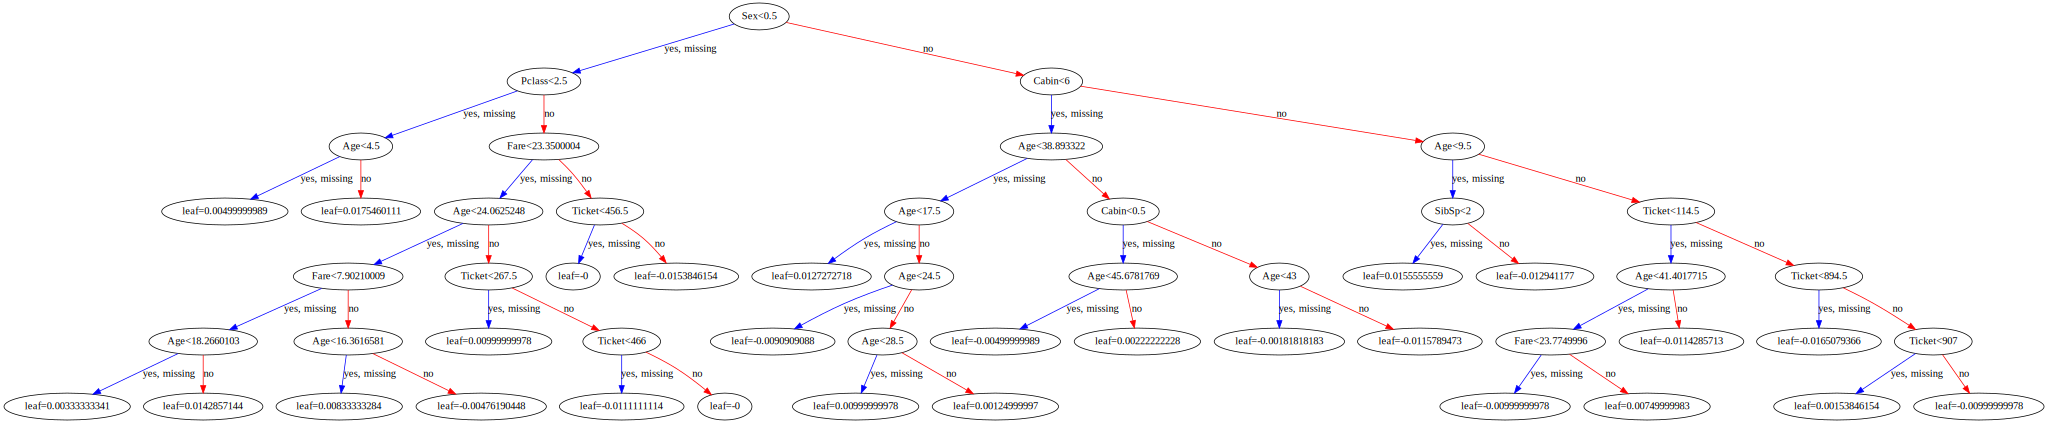

In [21]:
xgb.to_graphviz(modelXGB)

##### Feature importance

- From my point of view it doesn't look so obvious why our model picked up `Ticket` as the most important feature. My guess here would be that passengers in group has the best chance to escape the sinking ship. But strange that eliminating this feature gives worse accuracy score. So we will keep it as it is.

- Secondly, looks like `Age` contributes heavily to survival probability after whether the passenger was in group or alone. This drives to conclusion that passengers of particular age group have higher chances to survive.

- `Fare` and `Cabin` sector are the next deciders in this game of dice.

- Class and gender don't play so crucial role as it might appeared in the beginning.

- Apperantly a particular `Title` or whether the passenger is a parent or children (`Parch`) contribute very little to importance

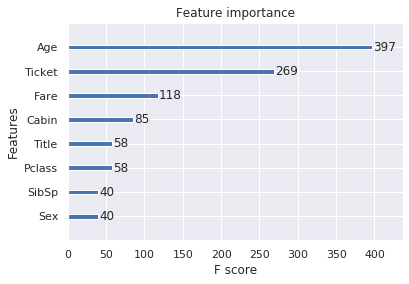

In [22]:
plot_importance(modelXGB)
plt.show()

#### scikit-learn: KNN - K Nearest Neighbours 

In [23]:
modelKNN = KNeighborsClassifier(n_neighbors=10)
modelKNN.fit(X_train, y_train)
predictions = modelKNN.predict(X_test)

##### Model overview

Quite a surprise -- KNN and Gradient Boosting ended up predicting with the same rate of accuracy!

In [24]:
print('Accuracy: %s' % accuracy_score(y_test, predictions.round()))
print('MSE: %s' % mean_squared_error(y_test, predictions.round()))

Accuracy: 0.8444444444444444
MSE: 0.15555555555555556


#### Neural network with multiple layers (Keras & TF)

In [25]:
neurons=len(testing_data.columns.values)
modelNN = Sequential([
    Dense(neurons * 8, input_dim=neurons, activation='relu'),
    Dense(neurons * 3, activation='relu'),
    Dense(neurons * 1, activation='relu'),
    Dense(1, activation='sigmoid'),
])

modelNN.compile(
    loss='mse',
    optimizer='adam',
    metrics=['accuracy']
)

modelNN.fit(
    X_train, y_train,
    epochs=5, batch_size=10,
    validation_data=(X_test, y_test),
    verbose = 1
)

Train on 846 samples, validate on 45 samples
Epoch 1/5
846/846 [==============================] - 0s 249us/step - loss: 0.3828 - accuracy: 0.6040 - val_loss: 0.2889 - val_accuracy: 0.7111
Epoch 2/5
846/846 [==============================] - 0s 145us/step - loss: 0.3407 - accuracy: 0.6454 - val_loss: 0.2690 - val_accuracy: 0.7111
Epoch 3/5
846/846 [==============================] - 0s 114us/step - loss: 0.2958 - accuracy: 0.6655 - val_loss: 0.2302 - val_accuracy: 0.7556
Epoch 4/5
846/846 [==============================] - 0s 119us/step - loss: 0.2798 - accuracy: 0.6572 - val_loss: 0.2824 - val_accuracy: 0.7111
Epoch 5/5
846/846 [==============================] - 0s 121us/step - loss: 0.2960 - accuracy: 0.6844 - val_loss: 0.1917 - val_accuracy: 0.8000


##### Model overview

In [26]:
loss, accuracy = modelNN.evaluate(X_test, y_test)
print("Accuracy: %s" % accuracy)
print("Loss: %s" % loss)

45/45 [==============================] - 0s 78us/step
Accuracy: 0.800000011920929
Loss: 0.19173308809598286


#### Convolutional Neural Network with 1x1 dimension (Keras & TF)

In [27]:
modelCNN = Sequential([
    Conv1D(filters=32, kernel_size=4, input_shape=(neurons,1)),
    Conv1D(filters=32, kernel_size=4, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.1),
    Flatten(),
    Dense(neurons * 4, activation='relu'),
    Dense(1, activation='sigmoid'),
])

modelCNN.compile(
   loss = 'mse',
   optimizer = 'adam',
   metrics = ['accuracy']
)

X_train_reshaped = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_reshaped = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

modelCNN.fit(
    X_train_reshaped, y_train,
    epochs=5, batch_size=10,
    validation_data=(X_test_reshaped, y_test),
    verbose = 1
)

Train on 846 samples, validate on 45 samples
Epoch 1/5
846/846 [==============================] - 0s 353us/step - loss: 0.5967 - accuracy: 0.3983 - val_loss: 0.7111 - val_accuracy: 0.2889
Epoch 2/5
846/846 [==============================] - 0s 157us/step - loss: 0.6068 - accuracy: 0.3901 - val_loss: 0.6683 - val_accuracy: 0.3111
Epoch 3/5
846/846 [==============================] - 0s 150us/step - loss: 0.3934 - accuracy: 0.6040 - val_loss: 0.2889 - val_accuracy: 0.7111
Epoch 4/5
846/846 [==============================] - 0s 248us/step - loss: 0.3889 - accuracy: 0.6111 - val_loss: 0.2889 - val_accuracy: 0.7111
Epoch 5/5
846/846 [==============================] - 0s 344us/step - loss: 0.3888 - accuracy: 0.6111 - val_loss: 0.2889 - val_accuracy: 0.7111


##### Model overview

Worst result! I know... this domain of problem is not suitable for CNN as the data set isn't large enough, so the model ended up underfitted -- I'm just experimenting :)

In [28]:
loss, accuracy = modelCNN.evaluate(X_test_reshaped, y_test)
print("Accuracy: %s" % accuracy)
print("Loss: %s" % loss)

45/45 [==============================] - 0s 62us/step
Accuracy: 0.7111111283302307
Loss: 0.28888889220025804


### Feed testing data set

In [29]:
TestDataReshaped = testing_data.to_numpy().reshape(testing_data.shape[0],testing_data.shape[1],1)
OutputCNN = testing_data.copy()
OutputCNN["Survived"] = modelCNN.predict_classes(TestDataReshaped)
OutputCNN['PassengerId'] = td_merged.PassengerId.astype(int)

In [30]:
OutputNN = testing_data.copy()
OutputNN["Survived"] = modelNN.predict_classes(testing_data.to_numpy())
OutputNN['PassengerId'] = td_merged.PassengerId.astype(int)

In [31]:
OutputXGB = testing_data.copy()
OutputXGB["Survived"] = np.array(
    modelXGB.predict(
        xgb.DMatrix(testing_data.to_numpy(), feature_names=testing_data.columns.values)
    ).round()
    ,dtype=int)
OutputXGB['PassengerId'] = td_merged.PassengerId.astype(int)

In [32]:
OutputKNN = testing_data.copy()
OutputKNN["Survived"] = modelKNN.predict(testing_data.to_numpy())
OutputKNN.Survived = OutputKNN.Survived.astype(int)
OutputKNN['PassengerId'] = td_merged.PassengerId.astype(int)

### Save predictions to file

In [33]:
OutputXGB[['PassengerId', 'Survived']].to_csv('output/XGB.csv', index=False)

In [34]:
OutputCNN[['PassengerId', 'Survived']].to_csv('output/CNN.csv', index=False)

In [35]:
OutputNN[['PassengerId', 'Survived']].to_csv('output/NN.csv', index=False)

In [36]:
OutputKNN[['PassengerId', 'Survived']].to_csv('output/KNN.csv', index=False)